In [1]:
import sys
import os

import pandas as pd
import numpy as np
from numpy import array
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

# Load in Data

9567

In [26]:
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df_coarse = pd.read_csv("../../dat/Final_Data_Beth.csv")

df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# add dive duration
coarse_features = ['diveDuration']

df = df.merge(df_coarse[['divenum']+coarse_features],
              on = 'divenum',
              how = 'left')

for feature in coarse_features:
    df.loc[df.duplicated(['ID','divenum']),feature] = np.nan

df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
#df['diveDuration'] = np.exp(df['diveDuration'])

df["delt_d"] = df["ad"].diff()
df["elev"] = -df["ad"]

df = df[df["ID"] == "D26"].iloc[0:1000]
df = df.reset_index()

jump_inds = list(range(df.shape[0]))#df.index[~np.isnan(df["diveDuration"])].to_list()

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_8602/1797503552.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")


In [27]:
# populate a data object
data = []

initial_ts = [0]
final_ts = []

features = ['diveDuration','aw1','aw2','aw3','w_low']

means = {feature: df[feature].mean() for feature in features}
stds = {feature: df[feature].std() for feature in features}

for feature in features:#['aw1','aw2','aw3']:
    df[feature] = (df[feature] - means[feature])/stds[feature]

for feature in ['diveDuration','w_low']:
    df[feature] = df[feature]/stds[feature]

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({feature : row[1][feature] for feature in features})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

print(initial_ts)
print(final_ts)

[0]
[999]


In [28]:
data

[{'diveDuration': 3.0518608300354213,
  'aw1': -2.785206634456928,
  'aw2': 4.553127552487195,
  'aw3': 2.4207991328204095,
  'w_low': 2.7485278571186678},
 {'diveDuration': nan,
  'aw1': -0.06574472433473647,
  'aw2': 0.23974280510424756,
  'aw3': 0.6046761310942411,
  'w_low': 0.8861119215367066},
 {'diveDuration': nan,
  'aw1': 0.1534219489282605,
  'aw2': -0.041569704473601594,
  'aw3': 0.4801955270860045,
  'w_low': 0.8762496843164929},
 {'diveDuration': nan,
  'aw1': 0.8986477553350696,
  'aw2': 0.8275339680420468,
  'aw3': 1.3234280896454274,
  'w_low': -0.1376404320291547},
 {'diveDuration': nan,
  'aw1': 1.204099238830925,
  'aw2': 2.185775852392371,
  'aw3': 2.0265716407101584,
  'w_low': 0.9411600116299619},
 {'diveDuration': nan,
  'aw1': 2.0214315597793258,
  'aw2': 3.8352629517862957,
  'aw3': 2.351826483708281,
  'w_low': 0.6308031945755309},
 {'diveDuration': nan,
  'aw1': 6.711530829661637,
  'aw2': 11.770308925422356,
  'aw3': 0.0596778620605147,
  'w_low': 0.99098038

# Plot Data

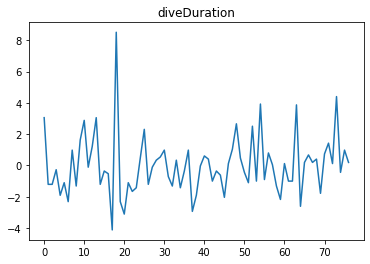

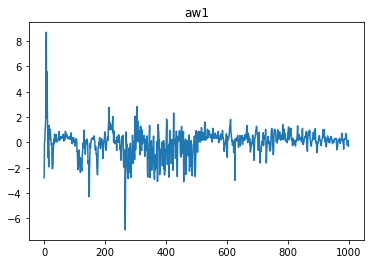

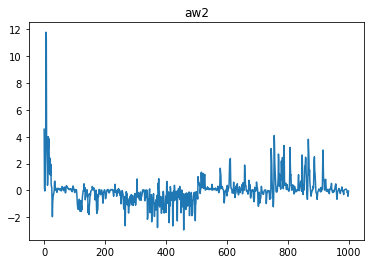

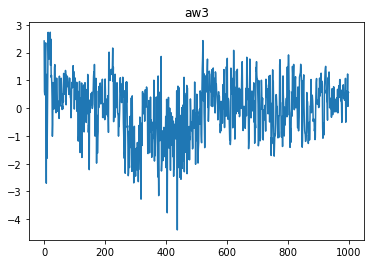

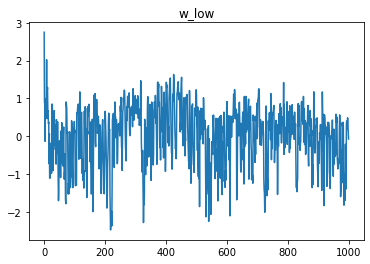

<AxesSubplot:>

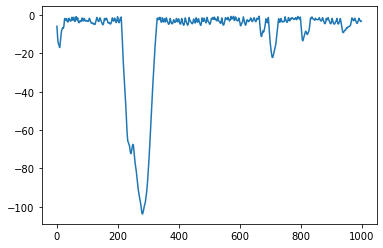

In [29]:
for feature in features:
    plt.plot([datum[feature] for datum in data[:1000] if not np.isnan(datum[feature])])
    plt.title(feature)
    plt.show()
    
df["elev"].iloc[0:1000].plot()

# Initialize HMM

In [30]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

K = [2,3]
T = len(data)

### pick distributions ###
features = {'diveDuration'     : {'f'           : 'normal',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': False,
                                  'share_fine'  : True},
            'aw1'              : {'f'           : 'normal',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': True,
                                  'share_fine'  : False},
            'aw2'              : {'f'           : 'normal',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': True,
                                  'share_fine'  : False},
            'aw3'              : {'f'           : 'normal',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': True,
                                  'share_fine'  : False},
            'w_low'            : {'f'           : 'normal',
                                  'lower_bound' : None,
                                  'upper_bound' : None,
                                  'share_coarse': True,
                                  'share_fine'  : False}}

### Shared Parameters ###
share_params = []

# share coarse scale dive duration
for feature in ['diveDuration']:
    for param in ['mu','log_sig']:
        for k0 in range(K[0]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0],
                                 "K_fine"  :[k1 for k1 in range(K[1])]})

# share fine scale acceleration
for feature in ['aw1','aw2','aw3']:
    for param in ['mu','log_sig']:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})
            
# share autocorrelation for acceleration
#for k1 in range(K[1]):
#    share_params.append({"features":['aw1','aw2','aw3'],
#                         "params"  :['logit_rho'],
#                         "K_coarse":[k0 for k0 in range(K[0])],
#                         "K_fine"  :[k1]})
            
# share params for "w_low"
for feature in ['w_low']:
    for param in ['mu','log_sig']:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})

# pick intial parameters
optim = stoch_optimizor.StochOptimizor(data,features,share_params,K)

optim.initial_ts = initial_ts
optim.final_ts = final_ts
optim.jump_inds = jump_inds

#for feature in features:
#    optim.param_bounds[feature] = {}
#    optim.param_bounds[feature]["mu"] = [-100,100]
#    optim.param_bounds[feature]["log_sig"] = [-5,5]


        
'''
optim.theta = [{'delt_d': {'mu': array([ -1.0, 0.0,  1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])},
                'w_low': {'log_mu': array([2.0, 2.0, 2.0]),
                          'log_sig': array([1.0, 1.0, 1.0])}},
               {'delt_d': {'mu': array([ -1.0, 0.0,  1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])},
                'w_low': {'log_mu': array([2.0, 2.0, 2.0]),
                          'log_sig': array([1.0, 1.0, 1.0])}}]

optim.eta = [array([[ 0.        , -3.0],
                    [-3.0,  0.        ]]),
             [array([[ 0.0  , -1.0  , -100.0],
                     [-100.0, 0.0   , -1.0  ],
                     [-1.0  , -100.0, 0.0   ]]),
              array([[ 0.0  , -2.0  , -100.0],
                     [-100.0, 0.0   , -2.0  ],
                     [-2.0  , -100.0, 0.0   ]])]]

optim.eta0 = [array([0.0, 0.0]),
             [array([0.0 , -100.0, -100.0]),
              array([0.0 , -100.0, -100.0])]]


optim.get_log_Gamma(jump=False)
optim.get_log_Gamma(jump=True)
optim.get_log_delta()
'''

# print initial parameters
print("initial theta:")
for theta_i in optim.theta:
    for feature in theta_i:
        print(feature)
        print(theta_i[feature])
        print("")
    print("")
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")

initial theta:
diveDuration
{'mu': array([-1.13208095, -1.13208095, -1.13208095]), 'log_sig': array([0.6504359, 0.6504359, 0.6504359])}

aw1
{'mu': array([-1.67168775,  0.73698803, -1.39427702]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}

aw2
{'mu': array([-0.36734979, -0.12867625, -1.16242928]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}

aw3
{'mu': array([-0.51876022, -0.41531208, -0.292137  ]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}

w_low
{'mu': array([ 0.17314258, -0.95537702,  0.29423205]), 'log_sig': array([-0.24051562, -0.24051562, -0.24051562])}


diveDuration
{'mu': array([-0.25868686, -0.25868686, -0.25868686]), 'log_sig': array([0.6504359, 0.6504359, 0.6504359])}

aw1
{'mu': array([-1.67168775,  0.73698803, -1.39427702]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}

aw2
{'mu': array([-0.36734979, -0.12867625, -1.16242928]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}

aw3
{'mu': array([-0.518

# Define Optimization Parameters

In [31]:
# parse command-line args
max_time = 10*60
id = 7

method_partialEs = [("control",0.0),
                    ("BFGS",0.0),
                    ("CG",0.0),
                    ("GD",0.0),
                    ("SAGA",0.0),
                    ("SAGA",0.5),
                    ("SAGA",1.0),
                    ("SVRG",0.0),
                    ("SVRG",0.5),
                    ("SVRG",1.0)]

rand_seed = [0,1,2,3,4,5,6,7,8,9]

# set methods
for i,settings0 in enumerate(product(rand_seed,method_partialEs)):
    if i == id:
        settings = settings0
        break

rand_seed = settings[0]
method = settings[1][0]
partial_E = settings[1][1]

random.seed(rand_seed)
np.random.seed(rand_seed)

print("method: %s" % method)
print("partial E_step: %.1f" % partial_E)
print("random seed: %d" % rand_seed)
print("max time : %.3f hours" % (max_time/3600))

# select parameters for optimization
num_epochs = 1000
tol = 1e-5
grad_tol = 1e-5

step_sizes = {"EM"  : [None,None],
              "CG"  : [None,None],
              "BFGS": [None,None],
              "GD"  : [0.005,0.005],
              "SGD" : [0.005,0.005],
              "SAG" : [0.005,0.005],
              "SVRG": [0.005,0.005],
              "SAGA": [0.005,0.005]}

### checks on optimization parameters ###
if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead","CG"]:
    raise("partial_E not consistent with method")

### lipschitz constants ###
if method == "control":
    optim.step_size = step_sizes["SAGA"]
    if not (step_sizes["SAGA"][0] is None):
        optim.L_theta = 1.0 / step_sizes["SAGA"][0] #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / step_sizes["SAGA"][1]
else:
    optim.step_size = step_sizes[method]
    if not (step_sizes[method][0] is None):
        optim.L_theta = 1.0 / (3.0 * step_sizes[method][0]) #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / (3.0 * step_sizes[method][1])

method: SVRG
partial E_step: 0.0
random seed: 0
max time : 0.167 hours


# Train the HMM

In [32]:
grad_buffer = "none"
weight_buffer = "none"

# print initial parameters
print("initial theta:")
print(optim.theta)
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")
print("parameter bounds:")
print(optim.param_bounds)
print("")
print("length of data:")
print(T)
print("")

# get optimal value via SAGA:
if method == "control":
    optim.train_HHMM_stoch(num_epochs=2*num_epochs,
                         max_time=max_time,
                         method="SAGA",
                         max_epochs=1,
                         partial_E=True,
                         tol=1e-4*tol,
                         grad_tol=1e-4*grad_tol,
                         record_like=True,
                         weight_buffer=weight_buffer,
                         grad_buffer=grad_buffer,
                         buffer_eps=1e-3)

elif partial_E == 0:
    optim.train_HHMM_stoch(num_epochs=num_epochs,
                          max_time=max_time,
                          method=method,
                          max_epochs=1,
                          partial_E=False,
                          tol=tol,
                          grad_tol=grad_tol,
                          record_like=True,
                          weight_buffer=weight_buffer,
                          grad_buffer=grad_buffer,
                          buffer_eps=1e-3)

elif partial_E == 0.5:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=1,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

elif partial_E == 1:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=10,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

initial theta:
[{'diveDuration': {'mu': array([-1.13208095, -1.13208095, -1.13208095]), 'log_sig': array([0.6504359, 0.6504359, 0.6504359])}, 'aw1': {'mu': array([-1.67168775,  0.73698803, -1.39427702]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}, 'aw2': {'mu': array([-0.36734979, -0.12867625, -1.16242928]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}, 'aw3': {'mu': array([-0.51876022, -0.41531208, -0.292137  ]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}, 'w_low': {'mu': array([ 0.17314258, -0.95537702,  0.29423205]), 'log_sig': array([-0.24051562, -0.24051562, -0.24051562])}}, {'diveDuration': {'mu': array([-0.25868686, -0.25868686, -0.25868686]), 'log_sig': array([0.6504359, 0.6504359, 0.6504359])}, 'aw1': {'mu': array([-1.67168775,  0.73698803, -1.39427702]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])}, 'aw2': {'mu': array([-0.36734979, -0.12867625, -1.16242928]), 'log_sig': array([-0.00050025, -0.00050025, -0.00050025])

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/stoch_optimizor.py:1116: RuntimeWarning: invalid value encountered in double_scalars
  elif ((ll_new - ll_old)/np.abs(ll_old)) < tol:


M-step failed to converge: maximum number of iterations reached
...done

L_theta:  133.33333333333132
alpha_theta:  0.0025000000000000378
L_eta:  33.31021332101391
alpha_eta:  0.010006940817849653


starting epoch 2.0

0.001 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-1.06331493, -1.06331493, -1.06331493]), 'log_sig': array([0.70764202, 0.70764202, 0.70764202])}, 'aw1': {'mu': array([-1.168252  ,  0.51992463, -0.86933757]), 'log_sig': array([ 0.20597058, -0.30830266,  0.09894565])}, 'aw2': {'mu': array([-0.34119677,  0.29778189, -0.6494382 ]), 'log_sig': array([-0.12083645,  0.04439044, -0.25602303])}, 'aw3': {'mu': array([-0.36305559,  0.08720624, -0.19014299]), 'log_sig': array([ 0.08608691, -0.07399585,  0.03130998])}, 'w_low': {'mu': array([ 0.34532347, -0.44060057,  0.43103784]), 'log_sig': array([-0.46313929, -0.2269809 , -0.57047021])}}, {'diveDuration': {'mu': array([-0.25115942, -0.25115942, -0.25115942]), 'log_sig': array([0

...done

current parameters:
[{'diveDuration': {'mu': array([-0.97305009, -0.97305009, -0.97305009]), 'log_sig': array([0.75508701, 0.75508701, 0.75508701])}, 'aw1': {'mu': array([-0.95344123,  0.35307284, -0.62954712]), 'log_sig': array([ 0.44411405, -0.8482823 , -0.05169585])}, 'aw2': {'mu': array([-0.44023078,  0.30190452, -0.55198249]), 'log_sig': array([ 0.01969112, -0.36114673, -0.60143114])}, 'aw3': {'mu': array([-0.50260768,  0.29953204, -0.25771335]), 'log_sig': array([ 0.14350892, -0.2173998 ,  0.00753307])}, 'w_low': {'mu': array([ 0.47918386, -0.31088643,  0.47505326]), 'log_sig': array([-0.48898916, -0.27725504, -0.68936316])}}, {'diveDuration': {'mu': array([-0.24873287, -0.24873287, -0.24873287]), 'log_sig': array([0.63635765, 0.63635765, 0.63635765])}, 'aw1': {'mu': array([-0.95344123,  0.35307284, -0.62954712]), 'log_sig': array([ 0.44411405, -0.8482823 , -0.05169585])}, 'aw2': {'mu': array([-0.44023078,  0.30190452, -0.55198249]), 'log_sig': array([ 0.01969112, -0.361

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  66.66666666665972
alpha_theta:  0.0050000000000005205
L_eta:  1.0373391743067786
alpha_eta:  0.321334951565952


starting epoch 12.0

0.011 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-0.71106179, -0.71106179, -0.71106179]), 'log_sig': array([0.73087751, 0.73087751, 0.73087751])}, 'aw1': {'mu': array([-0.56958599,  0.27700505, -0.69085762]), 'log_sig': array([ 0.73809712, -1.06420397, -0.16728433])}, 'aw2': {'mu': array([-0.07301021,  0.0739221 , -0.64981677]), 'log_sig': array([ 0.84734187, -1.16852475, -0.89195809])}, 'aw3': {'mu': array([-0.72933989,  0.40199823, -0.51550348]), 'log_sig': array([ 0.30430581, -0.41761324, -0.06412817])}, 'w_low': {'mu': array([ 0.45145727, -0.26488995,  0.39460267]), 'log_sig': array([-0.36313944, -0.26446773, -0.54845612])}}, {'diveDuration': {'mu': array([-0.23611061, -0.23611061, -0.23611061]), 'log_sig': array([0.6

...done

current parameters:
[{'diveDuration': {'mu': array([-0.5602489, -0.5602489, -0.5602489]), 'log_sig': array([0.70365941, 0.70365941, 0.70365941])}, 'aw1': {'mu': array([-0.19871756,  0.26595619, -0.77986939]), 'log_sig': array([ 0.64654215, -1.0896999 , -0.11897745])}, 'aw2': {'mu': array([ 0.29088056,  0.05611116, -0.71258528]), 'log_sig': array([ 0.75630876, -1.59860748, -0.82409138])}, 'aw3': {'mu': array([-0.6354976 ,  0.44668871, -0.59601289]), 'log_sig': array([ 0.3084948 , -0.51352709, -0.07458597])}, 'w_low': {'mu': array([ 0.32658448, -0.27032012,  0.38524794]), 'log_sig': array([-0.34164772, -0.25399893, -0.52600662])}}, {'diveDuration': {'mu': array([-0.22951162, -0.22951162, -0.22951162]), 'log_sig': array([0.61680558, 0.61680558, 0.61680558])}, 'aw1': {'mu': array([-0.19871756,  0.26595619, -0.77986939]), 'log_sig': array([ 0.64654215, -1.0896999 , -0.11897745])}, 'aw2': {'mu': array([ 0.29088056,  0.05611116, -0.71258528]), 'log_sig': array([ 0.75630876, -1.598607

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  33.33333333332709
alpha_theta:  0.010000000000001874
L_eta:  0.2589751689205046
alpha_eta:  1.2871246873697526


starting epoch 22.0

0.022 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-0.36854676, -0.36854676, -0.36854676]), 'log_sig': array([0.69280704, 0.69280704, 0.69280704])}, 'aw1': {'mu': array([ 0.36418259,  0.25805392, -0.84939521]), 'log_sig': array([ 0.41763442, -1.11132853, -0.01890943])}, 'aw2': {'mu': array([ 0.84343653,  0.04651015, -0.77159115]), 'log_sig': array([ 0.59605026, -1.66892528, -0.69120147])}, 'aw3': {'mu': array([-0.44098214,  0.4453995 , -0.65746649]), 'log_sig': array([ 0.32979257, -0.55030496, -0.06011946])}, 'w_low': {'mu': array([ 0.24473096, -0.27740028,  0.40593988]), 'log_sig': array([-0.33014392, -0.25069913, -0.5213568 ])}}, {'diveDuration': {'mu': array([-0.22306928, -0.22306928, -0.22306928]), 'log_sig': array([0.5

...done

current parameters:
[{'diveDuration': {'mu': array([-0.2852043, -0.2852043, -0.2852043]), 'log_sig': array([0.69566717, 0.69566717, 0.69566717])}, 'aw1': {'mu': array([ 0.60912641,  0.25240822, -0.86279142]), 'log_sig': array([ 0.32113803, -1.11524341,  0.02819286])}, 'aw2': {'mu': array([ 1.10490678,  0.03647477, -0.78025887]), 'log_sig': array([ 0.52943235, -1.7086281 , -0.63202369])}, 'aw3': {'mu': array([-0.32781916,  0.44314874, -0.69245187]), 'log_sig': array([ 0.31586208, -0.56882967, -0.03690327])}, 'w_low': {'mu': array([ 0.20084009, -0.28314556,  0.42435104]), 'log_sig': array([-0.35109506, -0.2504035 , -0.51521917])}}, {'diveDuration': {'mu': array([-0.22078472, -0.22078472, -0.22078472]), 'log_sig': array([0.55092434, 0.55092434, 0.55092434])}, 'aw1': {'mu': array([ 0.60912641,  0.25240822, -0.86279142]), 'log_sig': array([ 0.32113803, -1.11524341,  0.02819286])}, 'aw2': {'mu': array([ 1.10490678,  0.03647477, -0.78025887]), 'log_sig': array([ 0.52943235, -1.708628

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  66.66666666664919
alpha_theta:  0.00500000000000131
L_eta:  0.2589751689204768
alpha_eta:  1.2871246873698907


starting epoch 32.0

0.032 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-0.2075903, -0.2075903, -0.2075903]), 'log_sig': array([0.69976648, 0.69976648, 0.69976648])}, 'aw1': {'mu': array([ 0.80804007,  0.24868279, -0.85909907]), 'log_sig': array([ 0.14472862, -1.12372688,  0.10455969])}, 'aw2': {'mu': array([ 1.33587741,  0.03450721, -0.77819483]), 'log_sig': array([ 0.46583347, -1.7232934 , -0.57418542])}, 'aw3': {'mu': array([-0.20624917,  0.44442038, -0.71291161]), 'log_sig': array([ 0.29062775, -0.58032918, -0.01673857])}, 'w_low': {'mu': array([ 0.15466972, -0.28829167,  0.43839186]), 'log_sig': array([-0.38551021, -0.24963504, -0.50599774])}}, {'diveDuration': {'mu': array([-0.21691316, -0.21691316, -0.21691316]), 'log_sig': array([0.52118

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  66.666666666646
alpha_theta:  0.00500000000000155
L_eta:  0.25897516892046196
alpha_eta:  1.2871246873699644


starting epoch 38.0

0.039 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-0.16013016, -0.16013016, -0.16013016]), 'log_sig': array([0.71105628, 0.71105628, 0.71105628])}, 'aw1': {'mu': array([ 0.84875895,  0.24689714, -0.84011806]), 'log_sig': array([ 0.13741555, -1.12895288,  0.11291176])}, 'aw2': {'mu': array([ 1.4314532 ,  0.03404966, -0.76947413]), 'log_sig': array([ 0.45881856, -1.72644585, -0.56346495])}, 'aw3': {'mu': array([-0.15569864,  0.44367513, -0.71275114]), 'log_sig': array([ 0.28636712, -0.58549822, -0.01136637])}, 'w_low': {'mu': array([ 0.13873319, -0.29035599,  0.44251441]), 'log_sig': array([-0.39760617, -0.24968229, -0.50385139])}}, {'diveDuration': {'mu': array([-0.20156258, -0.20156258, -0.20156258]), 'log_sig': array([0.514

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  66.66666666664264
alpha_theta:  0.005000000000001802
L_eta:  0.25897516892044753
alpha_eta:  1.2871246873700362


starting epoch 44.0

0.045 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-0.1306804, -0.1306804, -0.1306804]), 'log_sig': array([0.75131234, 0.75131234, 0.75131234])}, 'aw1': {'mu': array([ 0.85946988,  0.24773683, -0.83480331]), 'log_sig': array([ 0.1403741 , -1.12718924,  0.11472603])}, 'aw2': {'mu': array([ 1.47948445,  0.03544019, -0.76730745]), 'log_sig': array([ 0.4586858 , -1.72110387, -0.56075916])}, 'aw3': {'mu': array([-0.13717699,  0.44293222, -0.7124508 ]), 'log_sig': array([ 0.28548128, -0.58277849, -0.00912768])}, 'w_low': {'mu': array([ 0.13459191, -0.28988838,  0.44380221]), 'log_sig': array([-0.39873408, -0.25019519, -0.50438455])}}, {'diveDuration': {'mu': array([-0.17310468, -0.17310468, -0.17310468]), 'log_sig': array([0.499

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  66.66666666663922
alpha_theta:  0.005000000000002059
L_eta:  0.2589751689204321
alpha_eta:  1.2871246873701128


starting epoch 50.0

0.052 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-0.11807675, -0.11807675, -0.11807675]), 'log_sig': array([0.78400953, 0.78400953, 0.78400953])}, 'aw1': {'mu': array([ 0.86620236,  0.24864265, -0.84151159]), 'log_sig': array([ 0.14343796, -1.12329286,  0.110465  ])}, 'aw2': {'mu': array([ 1.50377914,  0.03529206, -0.77180224]), 'log_sig': array([ 0.45966728, -1.71743995, -0.56584088])}, 'aw3': {'mu': array([-0.14054851,  0.44243758, -0.7128284 ]), 'log_sig': array([ 0.28731421, -0.57763159, -0.01031382])}, 'w_low': {'mu': array([ 0.13908738, -0.28819359,  0.44305013]), 'log_sig': array([-0.39265131, -0.25045743, -0.50698424])}}, {'diveDuration': {'mu': array([-0.13878474, -0.13878474, -0.13878474]), 'log_sig': array([0.5

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  33.333333333317995
alpha_theta:  0.0100000000000046
L_eta:  0.2589751689204162
alpha_eta:  1.2871246873701918


starting epoch 56.0

0.058 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-0.10380451, -0.10380451, -0.10380451]), 'log_sig': array([0.8168381, 0.8168381, 0.8168381])}, 'aw1': {'mu': array([ 0.87191975,  0.2496322 , -0.85395912]), 'log_sig': array([ 0.14424831, -1.12226704,  0.10479101])}, 'aw2': {'mu': array([ 1.51812059,  0.03538355, -0.77808257]), 'log_sig': array([ 0.45929351, -1.71507738, -0.57273466])}, 'aw3': {'mu': array([-0.15142681,  0.44108609, -0.7133762 ]), 'log_sig': array([ 0.28949011, -0.57308727, -0.01152489])}, 'w_low': {'mu': array([ 0.14719781, -0.28726371,  0.44314895]), 'log_sig': array([-0.3846482 , -0.25049866, -0.51238318])}}, {'diveDuration': {'mu': array([-0.10107855, -0.10107855, -0.10107855]), 'log_sig': array([0.50628

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  66.66666666663286
alpha_theta:  0.005000000000002535
L_eta:  0.2589751689204007
alpha_eta:  1.287124687370269


starting epoch 62.0

0.064 hours elapsed

starting E-step...
...done

current parameters:
[{'diveDuration': {'mu': array([-0.09344212, -0.09344212, -0.09344212]), 'log_sig': array([0.82723307, 0.82723307, 0.82723307])}, 'aw1': {'mu': array([ 0.87462844,  0.24988679, -0.86002752]), 'log_sig': array([ 0.14396773, -1.12151631,  0.10238552])}, 'aw2': {'mu': array([ 1.52104979,  0.03539076, -0.78129723]), 'log_sig': array([ 0.45905087, -1.71337579, -0.57639199])}, 'aw3': {'mu': array([-0.15759407,  0.44062035, -0.71383994]), 'log_sig': array([ 0.29077451, -0.57130595, -0.01249735])}, 'w_low': {'mu': array([ 0.15126737, -0.28678719,  0.44245835]), 'log_sig': array([-0.38083489, -0.25052063, -0.5145707 ])}}, {'diveDuration': {'mu': array([-0.07755564, -0.07755564, -0.07755564]), 'log_sig': array([0.50

# Save the HMM

In [42]:
optim.grad_eta_t[5]

[array([[ 0.00000000e+00,  1.98712759e-05],
        [-2.24459471e-03,  0.00000000e+00]]),
 [array([[ 0.00000000e+00, -1.84693060e-05, -1.86493381e-05],
         [ 1.12866211e-38,  0.00000000e+00, -1.61449471e-39],
         [ 4.71931026e-14, -3.21933568e-15,  0.00000000e+00]]),
  array([[ 0.00000000e+00, -2.15277166e-01, -6.09918965e-04],
         [ 1.05386749e-34,  0.00000000e+00, -3.49393541e-36],
         [ 7.88023307e-12, -2.27941728e-12,  0.00000000e+00]])]]

In [33]:
file = "case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)

if not os.path.isdir("../params/large/Mar-02-2023"):
    os.mkdir("../params/large/Mar-02-2023")

with open("../params/large/Mar-02-2023/" + file, 'wb') as f:
    pickle.dump(optim, f)

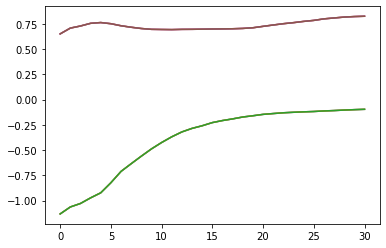

In [34]:
x = []
y = []
for theta in optim.theta_trace:
    x.append(theta[0]['diveDuration']['mu'])
    y.append(theta[0]['diveDuration']['log_sig'])
    
plt.plot(x)
plt.plot(y)

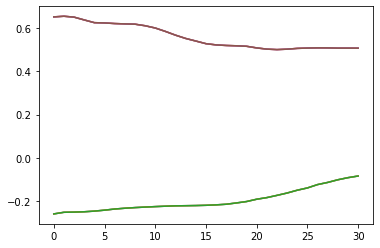

In [35]:
x = []
y = []
for theta in optim.theta_trace:
    x.append(theta[1]['diveDuration']['mu'])
    y.append(theta[1]['diveDuration']['log_sig'])
    
plt.plot(x)
plt.plot(y)

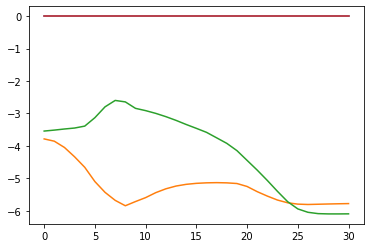

In [36]:
x = []
y = []
for eta in optim.eta_trace:
    x.append(eta[0].flatten())
    #y.append(eta[1])
    
plt.plot(x)
#plt.plot(y)